In [33]:
import pandas as pd
import numpy as np

from matplotlib import figure
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, auc

diabetesds = pd.read_csv('diabetes_prediction_dataset.csv')

***
### Further investigation

To know why our performance is not optimal were going to do a fast track through what we created in the Diabetes.ipynb

In [34]:
X = diabetesds.drop('diabetes', axis=1)  
y = diabetesds['diabetes']

categorical_columns = ['gender', 'smoking_history']
onehot_encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(onehot_encoder.fit_transform(X[categorical_columns]))

X_encoded.columns = onehot_encoder.get_feature_names_out(categorical_columns)
X_encoded = pd.concat([X_encoded, X.select_dtypes(include=['float64'])], axis=1)

label_encoder = LabelEncoder()
categorical_columns = ['gender', 'smoking_history']
diabetesds[categorical_columns] = diabetesds[categorical_columns].apply(lambda x: label_encoder.fit_transform(x))

***
I'm just going to make sure everything is converted in numericals so we dont run into issues whith modeling where we need numerical values. 

I've talked to a student about the possibilities of why the performance would be so low and he suggested to look at the outliers. So let's look at a few columns.
***

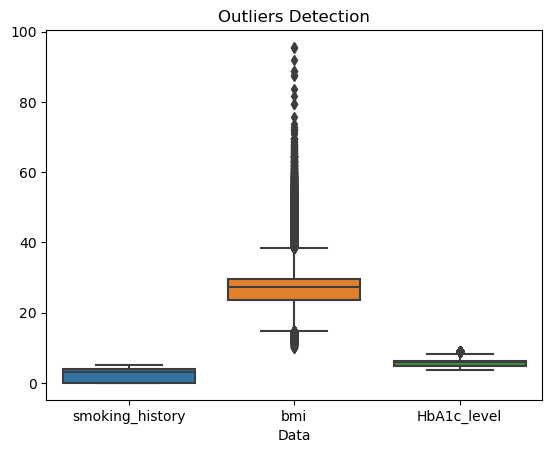

In [41]:
sns.boxplot(data=diabetesds[['smoking_history', 'bmi', 'HbA1c_level']])
plt.title("Outliers Detection")
plt.xlabel("Data")
plt.show()

***
As we can see there are some outliers. So my plan is to first split the dataset into train and test, then we'll undersample the dataset just as we have done in the other project. Then we will remove the outliers by using the IQR which removes outliers by a range. the IQR is the duifference between Q3 and Q1.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create the decision tree classifier
classifier = DecisionTreeClassifier()

# Train the classifier on the training data
classifier.fit(X_train, y_train)

# Make predictions on the testing data
predictions = classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.92665


*** 
here we undersample

In [36]:
rus = RandomUnderSampler(random_state=42)

X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

classifier.fit(X_train_undersampled, y_train_undersampled)

y_pred = classifier.predict(X_train_undersampled)
print(classification_report(y_train_undersampled, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6792
           1       1.00      0.98      0.99      6792

    accuracy                           0.99     13584
   macro avg       0.99      0.99      0.99     13584
weighted avg       0.99      0.99      0.99     13584



*** 
Let's use the IQR to remove outliers

In [37]:
Q1 = np.percentile(X_train_undersampled, 25, axis=0)
Q3 = np.percentile(X_train_undersampled, 75, axis=0)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_mask = (X_train_undersampled < lower_bound) | (X_train_undersampled > upper_bound)

X = X_train_undersampled[~outliers_mask.any(axis=1)]
y = y_train_undersampled[~outliers_mask.any(axis=1)]

classifier.fit(X, y)

DecisionTreeClassifier()

***
We also need to do the grid search as we did in the other project.

In [38]:
param_grid =  {    'criterion': ['gini', 'entropy'],
    'min_samples_split': [25, 30, 40, 50,54,53,52,55,56,57,60, 70, 80],
    'min_samples_leaf': [1, 2, 3, 4 , 5 ,],}   

model = DecisionTreeClassifier()

# Perform grid search using cross-validation
grid_search = GridSearchCV(classifier, param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X, y)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Use the best model for predictions
predictions = best_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.84845


***
Now, we do the ROC curve and check the score

Accuracy on entire dataset: 84.85
[[3454  499]
 [ 505 2170]]


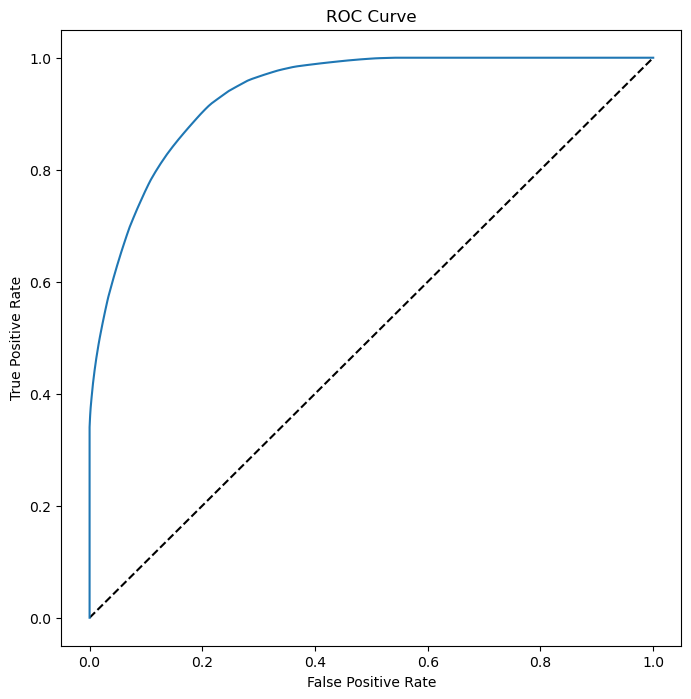

AUC:  0.94


In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score


entire_data_predictions = best_model.predict(X)

print(f'Accuracy on entire dataset: {accuracy_score(entire_data_predictions, y)*100:.2f}')

cm = confusion_matrix(y, entire_data_predictions)

print(cm)


y_pred_proba = best_model.predict_proba(X)[::,1]

fpr, tpr, _ = roc_curve(y,  y_pred_proba)


plt.figure(figsize=(8,8))

plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr, tpr)

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('ROC Curve')

plt.show()

auc = roc_auc_score(y, y_pred_proba)

print('AUC: ',round(auc, 2))

***
This is a great score. score between 0.90 and 1 are good scores which means ours (0.94) is pretty good.

Now we've learned that if the ROC curve performance does not give you a high score. You can look into the outliers to clean them and make your performance higher.